# Исследование мирового рынка компьютерных игр

## Введение

*Заказчик:* интернет-магазин компьютерных игр "Стримчик".

*Цели проекта:* изучение закономерностей в данных и проверка гипотез, которые могут помочь планировке рекламных кампаний и росту бизнеса. 

*Входные данные* — файл `games.csv` с данными о рейтингах и продажах компьютерных игр по платформам в различных регионах до 2016 года. Данные за 2016 год могут быть неполными.

*Описание данных:*

Файл `games.csv`: \
`Name` — название игры \
`Platform` — платформа \
`Year_of_Release` — год выпуска \
`Genre` — жанр игры \
`NA_sales` — продажи в Северной Америке (миллионы проданных копий) \
`EU_sales` — продажи в Европе (миллионы проданных копий) \
`JP_sales` — продажи в Японии (миллионы проданных копий) \
`Other_sales` — продажи в других странах (миллионы проданных копий) \
`Critic_Score` — оценка критиков (максимум 100) \
`User_Score` — оценка пользователей (максимум 10) \
`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

*План исследования:*
- Предобработка данных
- Исследовательский анализ: изучение продаж игр по платформам, выявление перспективных платформ, жанров, оценка влияния отзывов на продажи
- Составление портретов пользователей для различных регионов
- Проверка гипотез о равенстве рейтингов игр

## Загрузка и изучение данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Считаем csv-файл и сохраним в соответствующией переменной
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
# Выведем общую информацию и первые 10 строк датасета для ознакомления
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Наблюдаем существенное количество пропусков в столбцах с рейтингами Critic_Score, User_Score и Rating.

## Предобработка данных

Изменим названия столбцов, проведем работу с пропусками, типами данных, дубликатами, добавим столбец с суммарными продажами.

In [4]:
# Приведем названия столбцов к общепринятому регистру
data.columns = data.columns.str.lower()

Начнем с изучения пропусков в столбцах `name`, `genre` и `year_of_release`, поскольку их количество невелико.

In [5]:
# Изучим пропущенные значения в столбцах name и genre
data.loc[(data['name'].isna()) | (data['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропущенные значения в этих столбцах оказались в одних и тех же строках. Их можно удалить.

In [6]:
# Изучим пропущенные значения в столбце year_of_release
# Добавим сортировку по столбцу по продажам, чтобы понимать, насколько популярные игры попали в срез
display(data.loc[data['year_of_release'].isna()].sort_values(by='na_sales', ascending=False).head(10))
# Также вызовем метод describe для полноты картины
data.loc[data['year_of_release'].isna()].describe()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T
1506,Adventure,2600,NaN,Adventure,1.21,0.08,0.00,0.01,NaN,NaN,NaN
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,0.0,269.000000,269.000000,269.000000,269.000000,154.000000
mean,NaN,0.219888,0.090929,0.024907,0.032007,67.584416
std,NaN,0.424907,0.207933,0.090160,0.075546,14.828740
min,NaN,0.000000,0.000000,0.000000,0.000000,22.000000
25%,NaN,0.010000,0.000000,0.000000,0.000000,57.000000
50%,NaN,0.090000,0.020000,0.000000,0.010000,70.000000
75%,NaN,0.240000,0.100000,0.000000,0.030000,78.000000
max,NaN,4.260000,2.360000,0.770000,0.710000,94.000000


Наблюдаем, что хотя в срезе и есть несколько популярных игр, таких как Madden и Call of Duty, платформы, на которых они выходили, старые. Помимо того, средние продажи и трейтий квартиль по срезу крайне малы. Это, а также то, что количество строк с пропусками сравнительно невелико, дает нам достаточно оснований, чтобы их удалить.

In [7]:
# Удаляем пропуски в столбцах name, genre и year_of_release
data = data.dropna(subset=['name', 'year_of_release']).reset_index(drop=True)

Теперь перейдем к изучению пропусков в столбцах с рейтингами.

In [8]:
# Проверим, насколько много строк с пропусками имеют пропуски во всех трех столбцах
data.loc[(data['critic_score'].isna()) & (data['user_score'].isna()) & (data['rating'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16439,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16440,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16441,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16442,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Наблюдаем, что таких строк большинство.

Столбцы `critic_score` и `user_score`, судя по значениям в них, заполняются на основе данных из сервиса Metacritic, который был основан в январе 2001 года. На нем не представлены некоторые игры из 80-х и 90-х, что объясняет часть пропусков. Также выборочное изучение игр из среза выше [показывает](https://www.metacritic.com/game/winning-post-8-2016/), что пропуски у них связаны с отсутствием рецензий как таковых, например, из-за низкой популярности, что дополнительно подкрепляют данные о продажах. На основе этого заполнять данные такими значениями, как среднее или медиана, будет некорректно, лучше оставить пропуски.

Столбец `rating` заполняется на основе данных ESRB, которое было основано в сентябре 1994 года. Изучение FAQ на их [сайте](https://www.esrb.org/faqs/#do-video-game-retailers-support-and-enforce-the-esrb-rating-system) показало, что получение рейтинга является добровольным, а не обязательным. Таким образом, часть пропусков в этом столбце также объясняется отсутствием рейтинга как такового. Изучим этот столбец подробнее ниже.

In [9]:
# Изучим уникальные значения в столбцах critic_score и user_score
display(data['critic_score'].unique())
data['user_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце `user_score` наблюдаем значение 'tbd', что расшифровывается как to be determined. На основе полученной в ходе изучения данных выше информации, а также [FAQ](https://metacritichelp.zendesk.com/hc/en-us/articles/14482677385367-What-does-tbd-mean) Metacritic, мы знаем, что такое значение присваивается вместо рейтинга, когда игра имеет меньше 4 отзывов. Поскольку мы уже приравняли его к пропуску, заменим все значения tbd на NaN.

In [10]:
data = data.replace(to_replace='tbd', value=np.NaN)

In [11]:
# Изучим уникальные значения в столбце rating и количество записей с ними
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Наблюдаем четыре крупные категории:
- E (Everyone) - Без ограничений
- E10+ (Everyone 10+) - 10+
- T (Teen) - 13+
- M (Mature) - 17+

Также имеются четыре категории с крайне малым количеством записей, рассмотрим их по отдельности.
- EC (Early Childhood) - 3+, этот рейтинг в последнее время практически не используется, происходит отказ от него в пользу E. Ввиду схожести их критериев, имеет смысл отнести эти записи к категории E.
- K-A (Kids-Adults) - Без ограничений, это название использовалось для рейтинга E до 1998 года. Таким образом, тут также имеет смысл заменить значения на E.
- AO (Adults Only) - 18+, этот рейтинг сейчас используется, однако исторически его получало крайне небольшое количество игр. Это связано с тем, что все три крупных производителя консолей (Microsoft, Sony и Nintendo) на данный момент запрещают размещение игр с этим рейтингом на своих платформах. В связи с этим интересно его присутствие в данных в принципе, изучим это подробнее ниже.
- RP (Rating Pending) - эта оценка присваивается еще не вышедшим играм, которые проходят оценку ESRB, только для использования в трейлерах и промо-материалах. Игры, вышедшие в продажу, не могут иметь такую оценку, потому изучим запись с ней ниже.

In [12]:
# Заменяем категории EC и K-A на E
data = data.replace(to_replace=['EC', 'K-A'], value='E')
# Выводим строки с категориями AO и RP
data.query('(rating == "AO") or (rating == "RP")')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
864,Grand Theft Auto: San Andreas,XB,2005.0,Action,1.26,0.61,0.0,0.09,93.0,8.6,AO
14045,Supreme Ruler: Cold War,PC,2011.0,Strategy,0.00,0.03,0.0,0.01,63.0,6.8,RP


Информация в [интернете](https://www.google.com/search?client=opera&q=Grand+Theft+Auto%3A+San+Andreas+ao+rating&sourceid=opera&ie=UTF-8&oe=UTF-8) о ситуации с GTA: SA говорит, что рейтинг AO был присвоен ей временно, после чего изменен на M. Поступим так же.

В случае с Supreme Ruler, [страница](https://www.esrb.org/ratings/31253/supreme-ruler-cold-war/) ESRB для этой игры говорит, что она имеет рейтинг E10+. Обновим данные в датасете.

In [13]:
# Заменяем категории AO на M и RP на E10+
data = data.replace(to_replace={'AO': 'M', 'RP': 'E10+'})
# Проверяем проделанную работу
data['rating'].value_counts()

E       3932
T       2905
M       1537
E10+    1394
Name: rating, dtype: int64

Теперь попробуем обработать пропуски в столбце `rating`. Посмотрим на распределение рейтингов по жанрам, возможно, определенным жанрам чаще присваивают какой-то конкретный рейтинг? Поскольку переменная категориальная, для начала можно заполнить эти пропуски значением 'unknown', чтобы иметь понимание о количестве засписей с пропусками в каждом жанре.

In [14]:
# Заполняем пропуски, формируем сводную таблицу с рейтингами по жанрам
data['rating'] = data['rating'].fillna('unknown')
data.pivot_table(index=['genre', 'rating'], values='name', aggfunc='count')

name
genre        rating       
Action       E         411
             E10+      468
             M         597
             T         670
             unknown  1161
Adventure    E         161
             E10+       67
             M          98
             T         114
             unknown   853
Fighting     E           8
             E10+       19
             M          48
             T         357
             unknown   405
Misc         E         455
             E10+      166
             M          13
             T         228
             unknown   859
Platform     E         354
             E10+      141
             M           3
             T          63
             unknown   317
Puzzle       E         284
             E10+       42
             T          10
             unknown   233
Racing       E         576
             E10+       95
             M          18
             T         167
             unknown   370
Role-Playing E          83
             E10+      111
             M         161
             T         415
             unknown   711
Shooter      E          47
             E10+       56
             M         553
             T         340
             unknown   300
Simulation   E         321
             E10+       47
             M           5
             T         186
             unknown   298
Sports       E        1162
             E10+      105
             M          16
             T         195
             unknown   828
Strategy     E          70
             E10+       77
             M          25
             T         160
             unknown   341

В целом, однозначно судить о том, что определенным жанрам соответствуют определенные рейтинги, было бы неправильно. Так, в жанре Action все четыре рейтинга представлены в существенном количестве, тогда как в Sports явно преобладает рейтинг E. Также видим, что в жарне Role-Playing количество пропусков практически равно всем известным рейтингам, вместе взятым. В связи с этим, заполнять каким-то определенным значением пропуски было бы некорректно, потому можно оставить 'unknown'.

In [15]:
# Проверим результат работы с пропусками
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Следующий шаг - изменение типов данных. Небходимо изменить следующие столбцы:

- `year_of_release` - целочисленные данные (год выхода игры), нужен тип int
- `user_score` - дробные данные (средняя оценка пользователей с одним знаком после запятой), нужен тип float

In [16]:
# Изменим типы данных
data['year_of_release'] = data['year_of_release'].astype('int')
data['user_score'] = data['user_score'].astype('float')

Также проверим данные на наличие дубликатов.

In [17]:
# Проверим явные дубликаты
display(data.duplicated().sum())
# Проверим неявные дубликаты, для этого приведем данные к нижнему регистру
for column in data[['name','platform','genre']]:
    data[column] = data[column].str.lower()
data.duplicated(subset=['name', 'platform', 'year_of_release', 'genre']).sum()

0

1

Обнаружился один неявный дубликат, посмотрим на него.

In [18]:
data.loc[data.duplicated(subset=['name', 'platform', 'year_of_release', 'genre']) == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15969,madden nfl 13,ps3,2012,sports,0.0,0.01,0.0,0.0,83.0,5.5,E


In [19]:
# Ничего необычного, его можно удалить
data = data.drop(index=15969).reset_index(drop=True)

Последний шаг - подсчет суммарных продаж во всех регионах.

In [20]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16438,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16439,lma manager 2007,x360,2006,sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16440,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16441,spirits & spells,gba,2003,platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown,0.01


## Исследовательский анализ данных


### Посмотрим, сколько игр выпускалось в разные годы
Важны ли данные за все периоды?

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


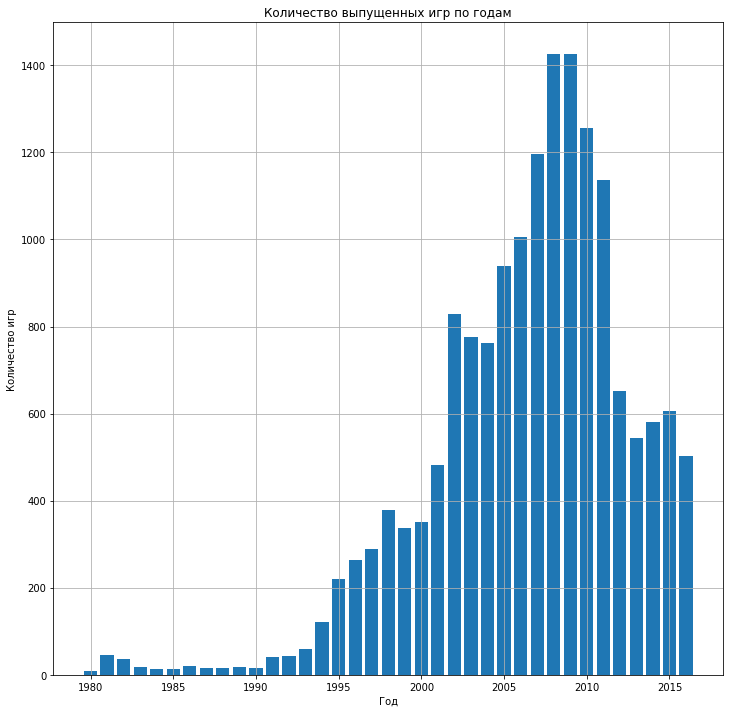

In [21]:
# Сформируем сводную таблицу
games_by_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
display(games_by_year)
# Построим столбчатую диаграмму
plt.figure(figsize=(12,12))
plt.grid(visible=True)
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.xticks(rotation=0)
plt.bar(games_by_year.index, games_by_year['name'].values);

На графике представлены данные с 1980 по 2016 годы. Видно, что с начала 1990-х и вплоть до конца 2000-х количество выпускаемых игр росло, с большим скачком в 2003-м, и пиком в 2008-2009, посе чего в 2012 резко сократилось и оставалось примерно на том же уровне.

В зависимости от исследуемых показателей, имеет смысл брать определенные срезы по годам и платформам, на которых выходили игры, полькольку фактически мы имеем выборку данных от зарождения игроиндустрии до современности, на эти данные влияло множество внешних факторов, таких как, например, технологический прогресс.

### Посмотрим, как менялись продажи по платформам
Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [22]:
# Сформируем сводную таблицу с топ-10 платформ по суммарным продажам
top_platforms = (data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
                     .sort_values(by='total_sales', ascending=False)
                     [:10])
top_platforms

,total_sales
platform,
ps2,1233.56
x360,961.24
ps3,931.33
wii,891.18
ds,802.78
ps,727.58
ps4,314.14
gba,312.88
psp,289.53


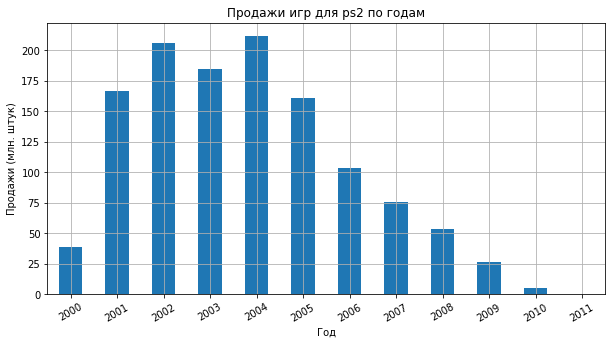

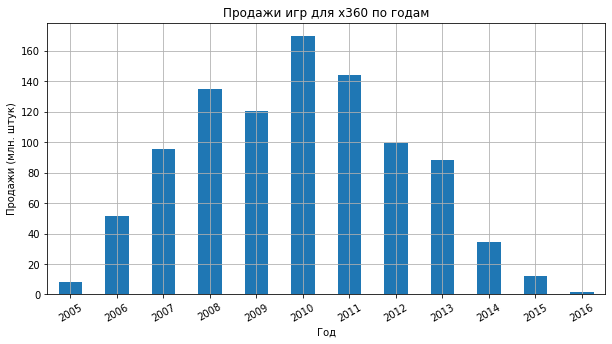

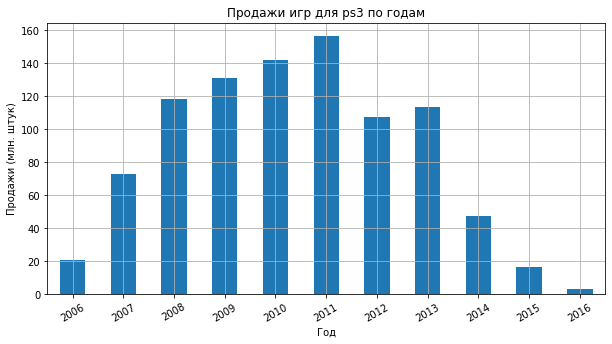

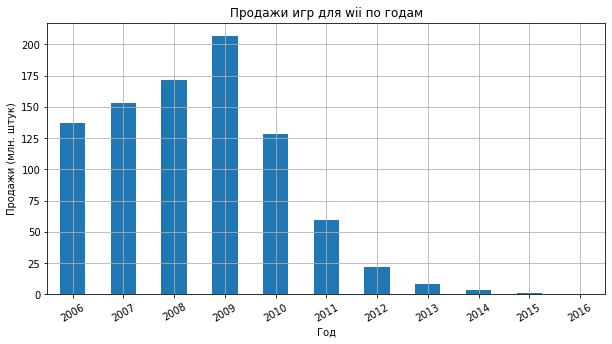

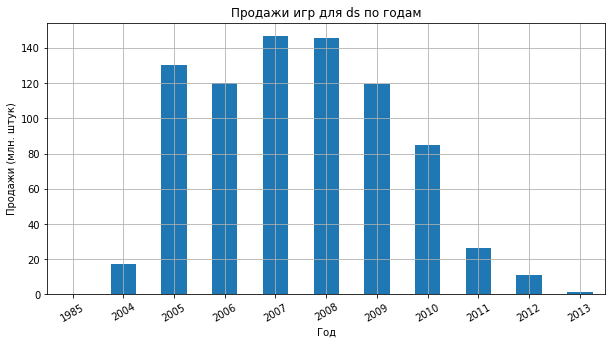

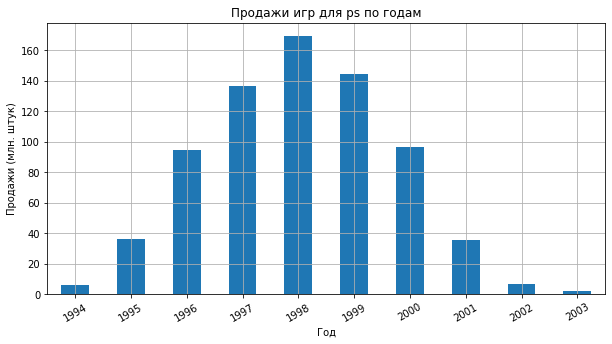

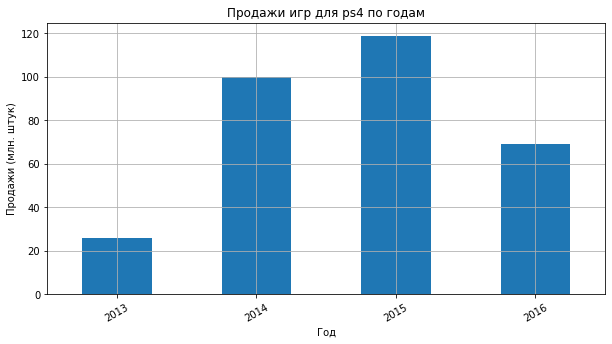

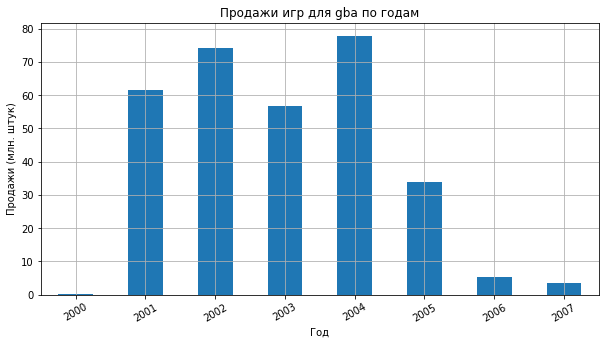

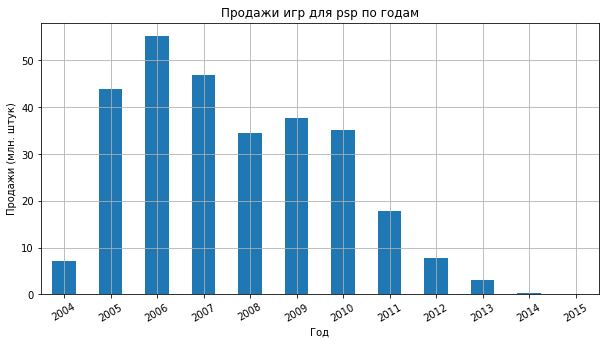

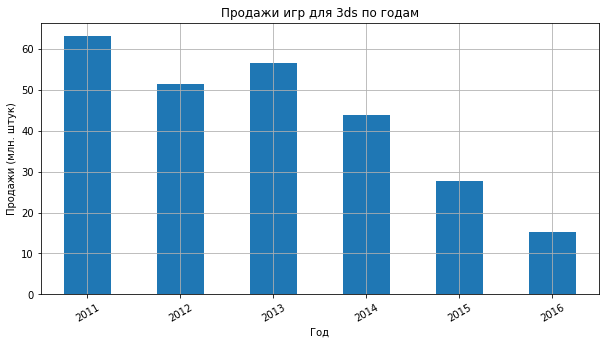

In [23]:
# Используя список выше, построим графики для этих платформ, используя цикл и сводные таблицы
for top_platform in top_platforms.index:
    (data.query('platform == @top_platform')
         .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
         .plot(kind='bar', legend=False, grid=True, figsize=(10,5), rot=30,
               title=(f'Продажи игр для {top_platform} по годам'), xlabel='Год', ylabel='Продажи (млн. штук)'))

Изучив графики выше, можно сделать следующие выводы:
- Для платформ, на которых игры больше не выходят (не выходили в 2016 году), не считая GameBoy Advance, жизненный цикл составлял от 9 до 11 лет, в среднем 10.
- Консоли Nintendo в среднем сразу после выхода обеспечивали существенные продажи (по отношению к продажам в последующие годы), тогда как по консолям от Sony и Microsoft продажи более равномерно росли до середины жизненного цилка платформы, после чего постепенно убывали.

Также обнаружились потенциально неверно заполненные данные для Nintendo DS, где у какого-то количества игр годы выпуска обозначен как 1985. Посмотрим на это внимательнее.

In [24]:
data.query('(platform == "ds") and (year_of_release == 1985)')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15704,strongest tokyo university shogi ds,ds,1985,action,0.0,0.0,0.02,0.0,NaN,NaN,unknown,0.02


Судя по доступным [данным](https://gamefaqs.gamespot.com/ds/937837-saikyou-toudai-shogi-ds/data) данная игра на DS вышла в 2007 году. Обновим данные.

In [25]:
data.loc[(data['platform'] == 'ds') & (data['year_of_release'] == 1985), 'year_of_release'] = 2007

### Возьмем данные за соответствующий актуальный период
Актуальный период определим в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не будем учитывать в дальнейшей работе данные за предыдущие годы.

За актуальный период можно взять промежуток с начала 2012 года по текущее время. В него попадут все платформы текущего поколения, и будет отражен актуальный объем рынка, который установился, начиная с 2012 года.

In [26]:
# Сделаем выборку за последние 5 лет
data_filtered = data.query('year_of_release >= 2012').reset_index(drop=True)
data_filtered

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,grand theft auto v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
3,pokemon x/pokemon y,3ds,2013,role-playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
4,call of duty: black ops ii,ps3,2012,shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
2880,strawberry nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
2881,aiyoku no eustia,psv,2014,misc,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
2882,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
2883,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01


### Какие платформы лидируют по продажам, растут или падают? 
Выберем несколько потенциально прибыльных платформ.

year_of_release,2012,2013,2014,2015,2016
platform,,,,,
3ds,51.36,56.57,43.76,27.78,15.14
ds,11.01,1.54,NaN,NaN,NaN
pc,23.22,12.38,13.28,8.52,5.25
ps3,107.35,113.25,47.76,16.82,3.60
ps4,NaN,25.99,100.00,118.90,69.25
psp,7.69,3.14,0.24,0.12,NaN
psv,16.19,10.59,11.90,6.25,4.25
wii,21.71,8.59,3.75,1.14,0.18
wiiu,17.56,21.65,22.03,16.35,4.60


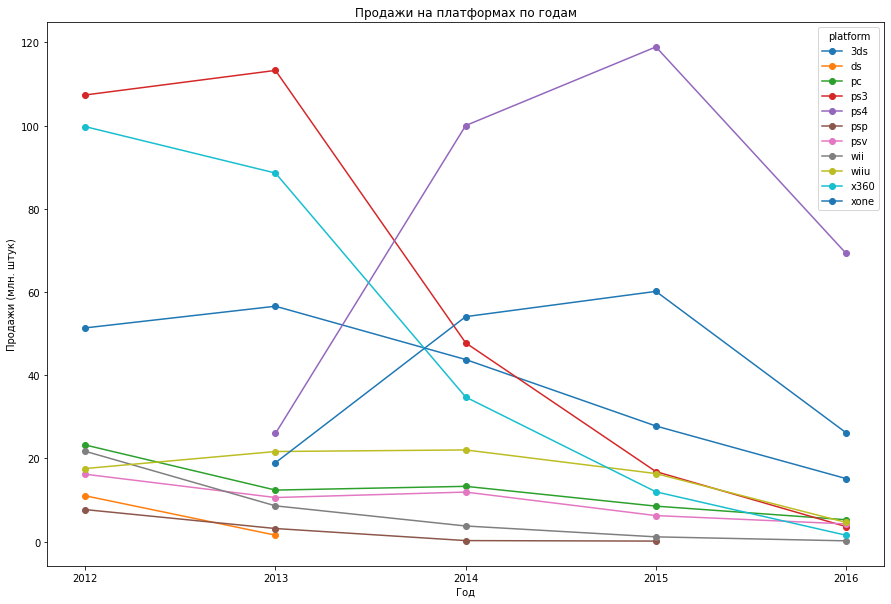

In [27]:
# Сформируем сводную таблицу с продажами по годам
display(data_filtered.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum'))
# Построим график
(data_filtered.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
              .plot(figsize=(15,10), style='o-', xticks=(2012, 2013, 2014, 2015, 2016),
                    title='Продажи на платформах по годам', 
                    xlabel='Год', ylabel='Продажи (млн. штук)'));

Судя по графику, наиболее популярные платформы в последние несколько лет - это PS4 и Xbox One. Это текущее поколение консолей, появившееся в 2013 году. На третьем месте находится 3DS, на четвертом - PC. Данные по текущему году не полные, потому делать вывод о том, что продажи сильно сократились год к году, было бы неправильно.

Среди платформ с сокращающимися продажами - прошлое поколение консолей, такие как PS3 и Xbox 360. Наблюдаем, что WiiU, вышедшая в 2012 году, не пользуется такой же популярностью, как консоли от Sony и Microsoft, вышедшие годом позже.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам


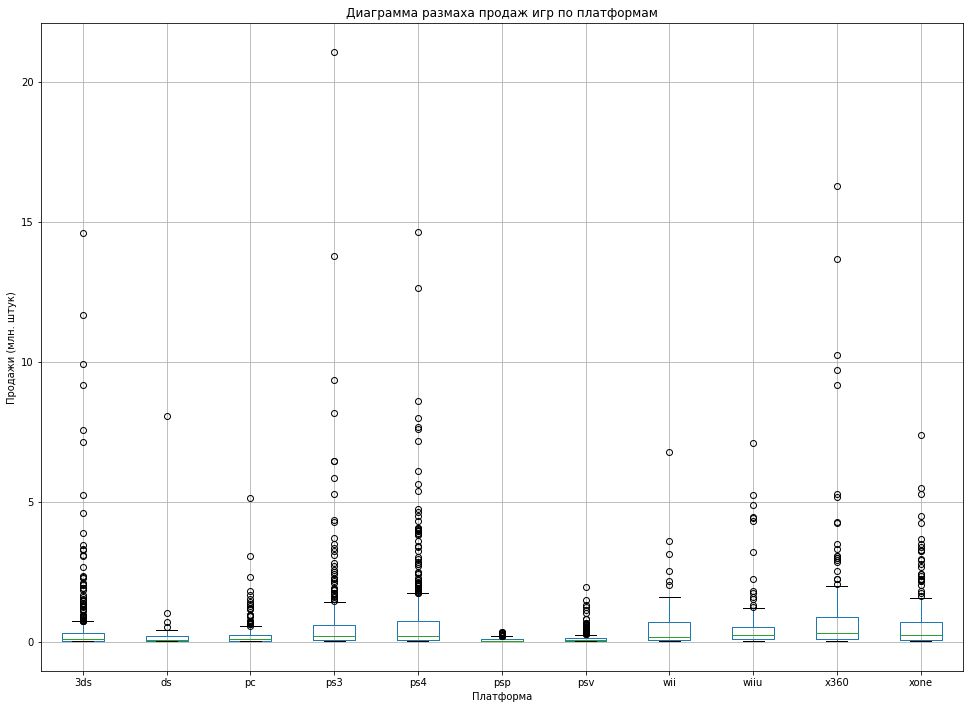

In [28]:
# Построим диаграммы размаха для всех платформ в выборке
data_filtered.boxplot(column='total_sales', by='platform', figsize=(16, 12))
plt.suptitle('')
plt.title('Диаграмма размаха продаж игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн. штук)')
plt.show()

Наблюдаем, что самые продаваемые игры среди актуальных платформ выходили на PS4 и 3DS, с общими продажами практически в 15 млн. На Xbox One и WiiU тираж самых продаваемых игр составил около 8 млн. Видно, что в целом количество выбросов, т.е. игр с высокими продажами, на 3DS и PS4 больше, чем на WiiU и Xbox One.

Чтобы изучить медиану и квартили, построим тот же график, укрупнив масштаб.

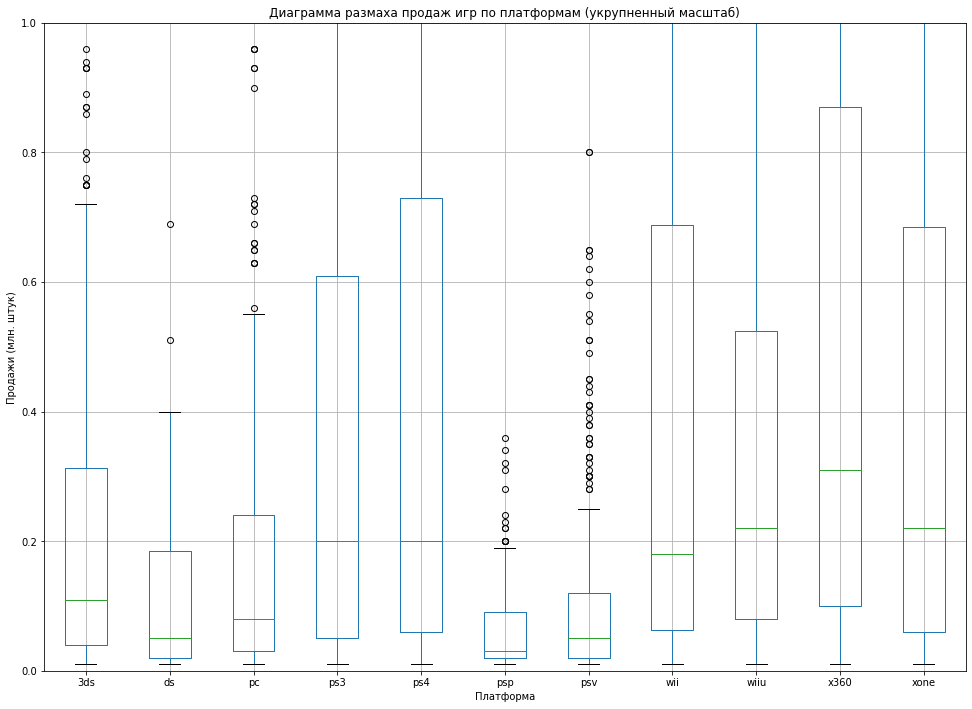

In [29]:
# Укрупним масштаб, чтобы лучше видеть квартили и медиану
data_filtered.boxplot(column='total_sales', by='platform', figsize=(16, 12))
plt.suptitle('')
plt.title('Диаграмма размаха продаж игр по платформам (укрупненный масштаб)')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн. штук)')
plt.ylim(0, 1)
plt.show()

Наблюдаем, что медианное значение продаж для всех платформ (за исключением Xbox 360, который относится к прошлому поколению консолей), не превышает 250 тысяч. При этом для WiiU и Xbox One оно одинаково, у PS4 немного ниже, а для 3DS ощутимо ниже. Третий квартиль у PS4 и Xbox One находится около 700 тысяч, для WiiU он немногим выше 500 тысяч, тогда как у 3DS он находится около 300 тысяч.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [31]:
# Зададим функцию, которая построит диаграммы рассеяния и выведет коэффиценты корреляции 
# для переданных ей платформ из переданного ей датафрейма
def score_sales_corr(df, platforms):
    for platform in platforms:
        data_platform = df.query('platform == @platform')
        print(f'Платформа: {platform}')
        print('Коэффицент корреляции оценок пользователей к продажам:', 
              data_platform['user_score'].corr(data_platform['total_sales']).round(2))
        data_platform.plot(kind='scatter', x='user_score', y='total_sales', 
                           figsize=(8, 6), grid=True, alpha=0.5,
                           title=f'Диаграмма корреляции оценок пользователей к продажам игр для {platform}',
                           xlabel='Оценка пользователей', ylabel='Продажи (млн. штук)');
        plt.show()
        print('Коэффицент корреляции оценок критиков к продажам:', 
              data_platform['critic_score'].corr(data_platform['total_sales']).round(2))
        data_platform.plot(kind='scatter', x='critic_score', y='total_sales', 
                           figsize=(8, 6), grid=True, alpha=0.5, 
                           title=f'Диаграмма корреляции оценок критиков к продажам игр для {platform}',
                           xlabel='Оценка критиков', ylabel='Продажи (млн. штук)');     
        plt.show()
        print()
    return

В качестве рассматриваемой платформы выберем PS4, как платформу с наибольшими продажами из актуального поколения консолей.

Платформа: ps4
Коэффицент корреляции оценок пользователей к продажам: -0.03


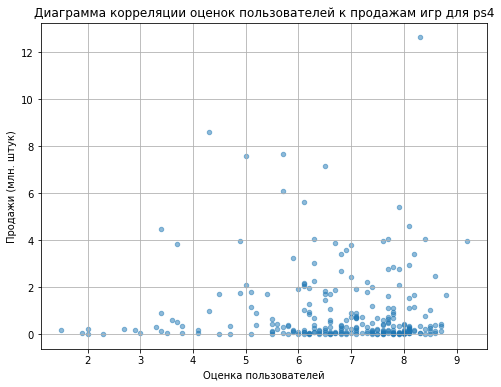

Коэффицент корреляции оценок критиков к продажам: 0.41


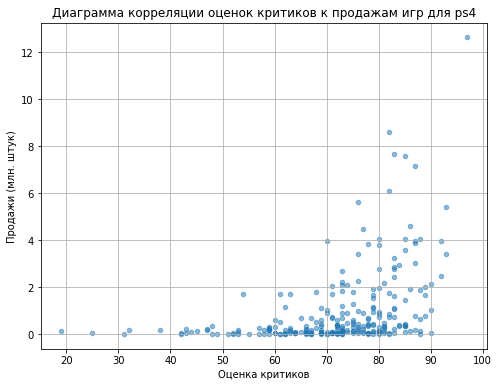

In [32]:
# С помощью функции построим графики и посчитаем коэффиценты для игр для PS4
score_sales_corr(data_filtered, ['ps4'])

Согласно шкале Чеддока, связь между оценками пользователей и продажами отсутствует. Между оценками критиков и продажами связь умеренная. 

Действительно, по диаграммам рассеяния видно, что игр с продажами более 1 млн и рейтингом критиков менее 70 практически нет, тогда как среди игр с оценкой пользователей менее 7 достаточно много выбросов с большими продажами. В обоих случаях также наблюдаем пласт игр с оценками выше 6, которые не пользовались особой популярностью, что также влияет на коэффицент корреляции.

### Соотнесем выводы с продажами игр на других платформах

Рассмотрим оставшиеся платформы из наиболее популярных - Xbox One, 3DS и PC. Также рассмотрим PS3, чтобы сравнить полученные данные с данными по PS4.

Платформа: xone
Коэффицент корреляции оценок пользователей к продажам: -0.07


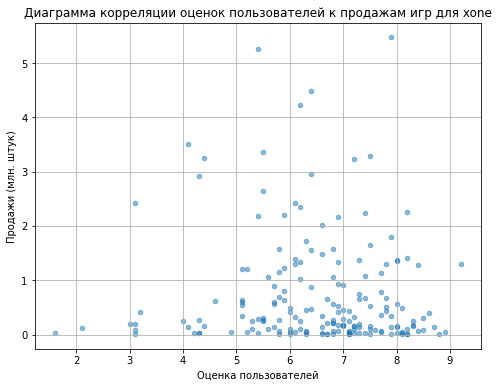

Коэффицент корреляции оценок критиков к продажам: 0.42


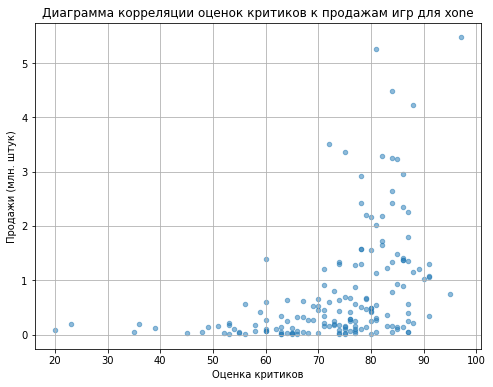


Платформа: 3ds
Коэффицент корреляции оценок пользователей к продажам: 0.2


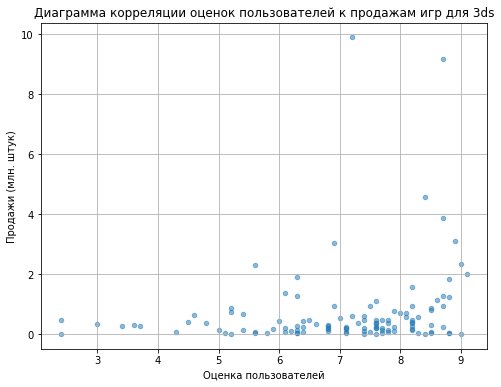

Коэффицент корреляции оценок критиков к продажам: 0.32


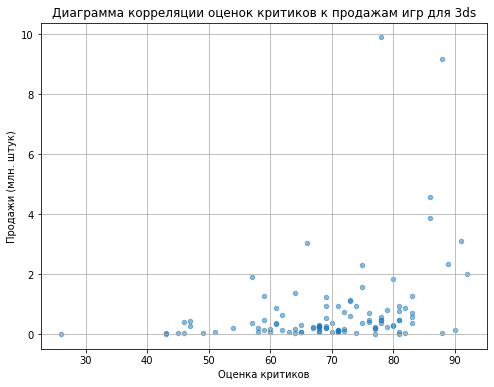


Платформа: pc
Коэффицент корреляции оценок пользователей к продажам: -0.12


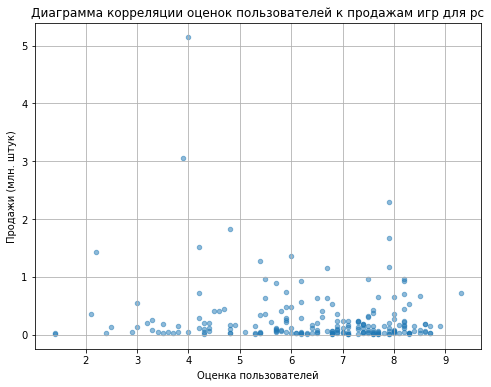

Коэффицент корреляции оценок критиков к продажам: 0.24


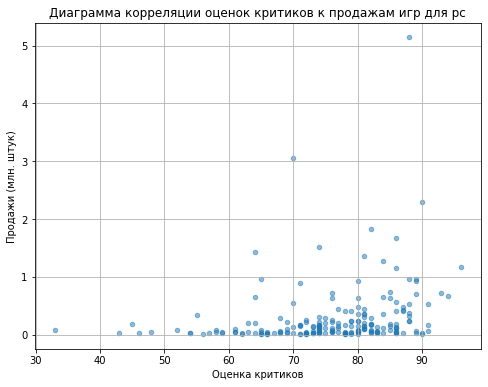


Платформа: ps3
Коэффицент корреляции оценок пользователей к продажам: -0.01


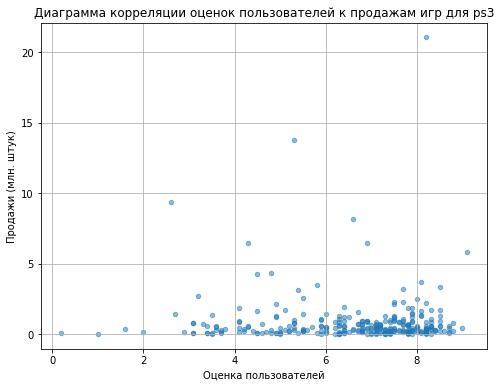

Коэффицент корреляции оценок критиков к продажам: 0.33


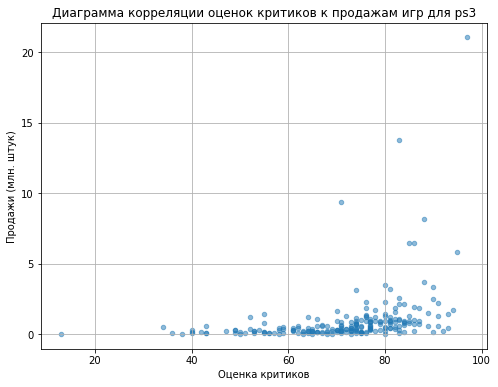

In [33]:
score_sales_corr(data_filtered, ['xone', '3ds', 'pc', 'ps3'])

Общая картина по другим платформам, включая PS3, соответствуем выводам, сделанным на основе данных по играм для PS4.

Отзывы пользователей не влияют на итоговые продажи игр, тогда как мнения критиков в этом контексте более важны. Небольшие отклонения в корреляции имеют PC, где оценки критиков меньше влияют на продажи, чем на других платформах, и 3DS, где уже оценки пользователей больше коррелируют с итоговыми продажами.

### Посмотрим на общее распределение игр по жанрам
Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

,total_sales
genre,
action,441.12
shooter,304.73
role-playing,192.80
sports,181.06
misc,85.04
platform,61.00
racing,53.50
fighting,44.49
simulation,35.12


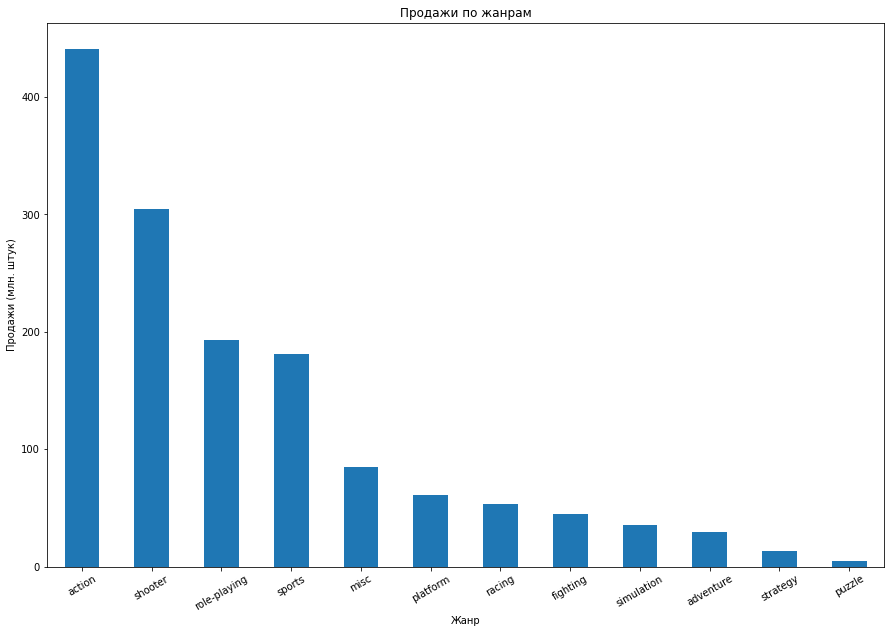

In [34]:
# Сформируем сводную таблицу
display(data_filtered.pivot_table(index='genre', values='total_sales', aggfunc='sum')
                     .sort_values(by='total_sales', ascending=False))
# Построим столбчатую диаграмму
(data_filtered.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
              .plot(kind='bar', figsize=(15,10), legend=False, rot=30, 
                    title='Продажи по жанрам', 
                    xlabel='Жанр', ylabel='Продажи (млн. штук)'));

Наблюдаем, что больше всего продаж в жанрах Action, Shooter и Role-Playing, меньше всего - в жанрах Puzzle, Strategy и Adventure. Точно судить о прибыльности, не имея данных о стоимости игр, было бы некорректно, но в целом логично заключить, что наиболее популярные жанры будут для магазина наиболее прибыльными.

Разумно будет также посмотреть распределение продаж в жанрах по годам, это может помочь выявить какие-то тенденции.

year_of_release,2012,2013,2014,2015,2016
genre,,,,,
action,119.25,122.51,97.23,72.02,30.11
adventure,5.79,6.09,5.57,8.16,3.82
fighting,9.18,7.09,15.85,7.90,4.47
misc,22.22,25.27,23.38,11.57,2.60
platform,18.37,24.54,8.81,6.05,3.23
puzzle,1.72,0.96,1.49,0.71,0.01
racing,13.61,12.37,16.66,8.07,2.79
role-playing,46.91,44.45,45.62,37.64,18.18
shooter,71.75,62.04,65.21,67.51,38.22


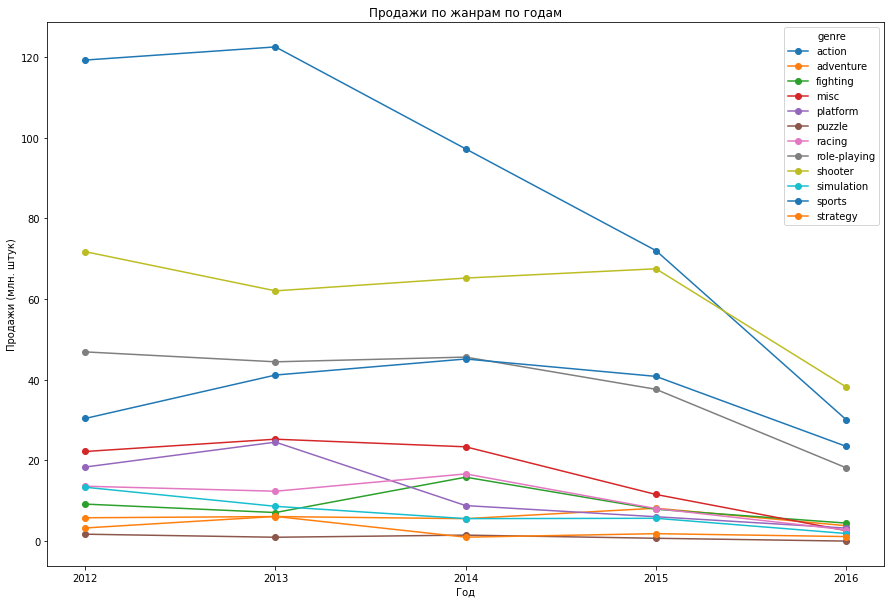

In [35]:
# Сформируем сводную таблицу, добавив группиовку по годам
display(data_filtered.pivot_table(index='genre', columns='year_of_release', values='total_sales', aggfunc='sum'))
# Построим график
(data_filtered.pivot_table(index='year_of_release', columns='genre', values='total_sales', aggfunc='sum')
              .plot(figsize=(15,10), style='o-', xticks=(2012, 2013, 2014, 2015, 2016),
                    title='Продажи по жанрам по годам', 
                    xlabel='Год', ylabel='Продажи (млн. штук)'));

Наблюдаем, что жанр Action последние 5 лет был самым популярным, уступая первенство только в текущем году, о котором у нас неполные данные, однако за последние 3 года его популярность значительно сократилась. Продажи в жанрах Shooter, Sports и Role-Playing в последние годы оставались относительно стабильными.

Игр в жанрах Puzzle, Strategy и Adventure за последние годы действительно продавалось стабильно мало.

#### Диаграммы размаха

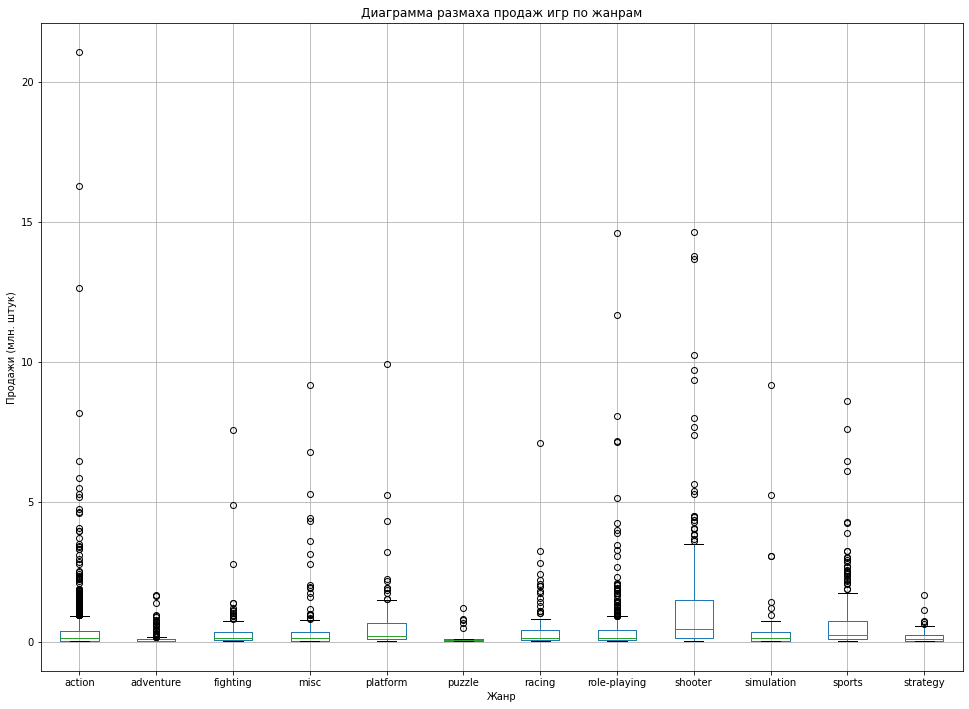

In [36]:
# Построим диаграммы размаха по жанрам<div class="alert alert-info">      
data_filtered.boxplot(column='total_sales', by='genre', figsize=(16, 12))
plt.suptitle('')
plt.title('Диаграмма размаха продаж игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи (млн. штук)')
plt.show()

Наблюдаем несколько очень больших выбросов в жанре Action. В жанрах Shooter и Role-Playing тиражи самых продаваемых игр также достаточно велики. Условно игры с продажами свыше 5 млн можно охарактеризовать как хиты, таковых не так много. 

Чтобы изучить медиану и квартили, построим тот же график, укрупнив масштаб.

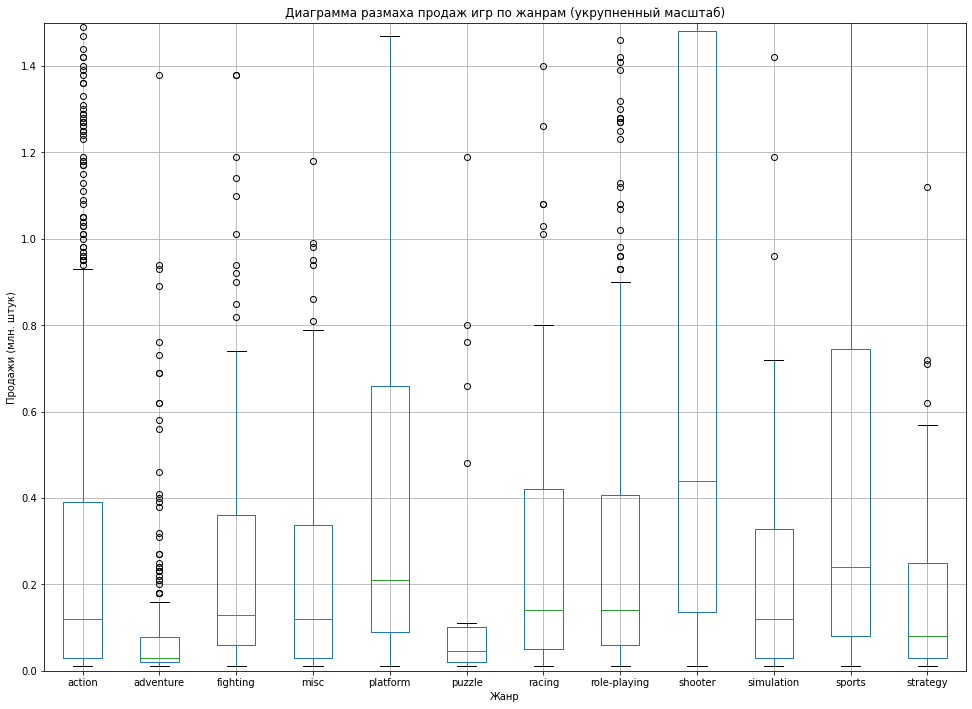

In [37]:
# Укрупним масштаб, чтобы лучше видеть квартили и медиану
data_filtered.boxplot(column='total_sales', by='genre', figsize=(16, 12))
plt.suptitle('')
plt.title('Диаграмма размаха продаж игр по жанрам (укрупненный масштаб)')
plt.xlabel('Жанр')
plt.ylabel('Продажи (млн. штук)')
plt.ylim(0, 1.5)
plt.show()

Тут сильно выделяются показатели жанра Shooter - медиана (~ 400 тысяч) и третий квартиль (~ 1.45 млн.) намного больше, чем у любого другого жанра, в том числе Action, где медиана и третий квартиль по сравнению со значениями выбросов довольно малы. Интересно, что медианное значение жанра Platform оказалось третьим по величине. 

Видно, что жанры Puzzle и Adventure действительно не пользуются польшой популярностью, тогда как в жанре Strategy, несмотря на низкие общие продажи, третий квартиль существенно больше.

### Промежуточный вывод

На основе проведенных исследований можно сделать следующие выводы:
1. В последние годы количество выпускаемых игр существенно сократилось по отношению к пику 2008-2009 года, но начиная с 2012 оставалось стабильным.
2. Срок жизни платформы в среднем составляет 10 лет. При этом консоли Nintendo склонны в первые же годы приносить хорошие продажи, тогда как консоли Sony и Microsoft после выпуска более плавно растут в тиражах игр вплоть до середины жизненного цикла, после чего продажи начинают сокращаться.
3. Для исследования решили использовать данные с 2012 года включительно, как наиболее репрезентативные.
4. В этом периоде наиболее популярными стали актуальные PS4, Xbox One и 3DS, тогда как уходящее поколение консолей стабильно сокращается в тиражах проданных игр.
5. Медианные продажи игр на 3DS ощутимо меньше, чем на PS4 и Xbox One.
6. Отзывы пользователей не имеют корреляции с итоговыми продажами игр, рейтинги критиков - имеют умеренную. Продажи игр для Nintendo 3DS меньше коррелируют с отзывами критиков.
7. Жанры с наибольшими общими продажами - Action, Shooter и Role-Playing, наименьшими - Puzzle, Strategy и Adventure.
8. Медианные и квартильные значения указывают на большой потенциал жанра Shooter. Жанры Puzzle и Adventure являются аутсайдерами.

## Портрет пользователя по регионам

Определим для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5)
- Самые популярные жанры (топ-5)
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Зададим функцию, которая построит три круговые диаграммы с распределениями для платформ, жанров и рейтингов ESRB на основе переданного ей датафрейма и аргумента. При постройке графиков по платформам и жанрам значения, не относящиеся к топ-5, будут сгруппированы в категорию 'other' и также отражены на графиках.

In [39]:
def regional_top(df, value):
    if value == 'platform':
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))
        fig.tight_layout()
        plt.suptitle('Доли платформ по рынкам')
#       Сбор данных по Северной Америке с группировкой   
        pie_data_na = (df.pivot_table(index='platform', values='na_sales', aggfunc='sum')
                        .sort_values(by='na_sales', ascending=False))
        pie_data_na_top = pie_data_na.head()
        pie_data_na_top.loc['other'] = pie_data_na.loc[~pie_data_na.index.isin(pie_data_na_top.index), 'na_sales'].sum() 
#       Постройка графика по Северной Америке  
        plt.subplot(1, 3, 1)
        plt.title('Северная Америка')
        plt.pie(x=pie_data_na_top['na_sales'], autopct='%.2f', radius=1.1, labels=pie_data_na_top.index)
#       Сбор данных по Европе         
        pie_data_eu = (df.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
                        .sort_values(by='eu_sales', ascending=False))
        pie_data_eu_top = pie_data_eu.head()
        pie_data_eu_top.loc['other'] = pie_data_eu.loc[~pie_data_eu.index.isin(pie_data_eu_top.index), 'eu_sales'].sum() 
#       Постройка графика по Европе         
        plt.subplot(1, 3, 2)
        plt.title('Европа')
        plt.pie(x=pie_data_eu_top['eu_sales'], autopct='%.2f', radius=1.1, labels=pie_data_eu_top.index) 
#       Сбор данных по Японии         
        pie_data_jp = (df.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
                        .sort_values(by='jp_sales', ascending=False))
        pie_data_jp_top = pie_data_jp.head()
        pie_data_jp_top.loc['other'] = pie_data_jp.loc[~pie_data_jp.index.isin(pie_data_jp_top.index), 'jp_sales'].sum()  
#       Постройка графика по Японии         
        plt.subplot(1, 3, 3)
        plt.title('Япония')
        plt.pie(x=pie_data_jp_top['jp_sales'], autopct='%.2f', radius=1.1, labels=pie_data_jp_top.index)              

    elif value == 'genre':
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))
        fig.tight_layout()
        plt.suptitle('Доли жанров по рынкам')
#       Сбор данных по Северной Америке          
        pie_data_na = (df.pivot_table(index='genre', values='na_sales', aggfunc='sum')
                        .sort_values(by='na_sales', ascending=False))
        pie_data_na_top = pie_data_na.head()
        pie_data_na_other = pie_data_na.loc[~pie_data_na.index.isin(pie_data_na_top.index), 'na_sales'].sum().copy()
        pie_data_na_top.loc['other'] = pie_data_na_other
#       Постройка графика по Северной Америке         
        plt.subplot(1, 3, 1)
        plt.title('Северная Америка')
        plt.pie(x=pie_data_na_top['na_sales'], autopct='%.2f', radius=1.1, labels=pie_data_na_top.index)
#       Сбор данных по Европе         
        pie_data_eu = (df.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
                        .sort_values(by='eu_sales', ascending=False))
        pie_data_eu_top = pie_data_eu.head()
        pie_data_eu_top.loc['other'] = pie_data_eu.loc[~pie_data_eu.index.isin(pie_data_eu_top.index), 'eu_sales'].sum() 
#       Постройка графика по Европе         
        plt.subplot(1, 3, 2)
        plt.title('Европа')
        plt.pie(x=pie_data_eu_top['eu_sales'], autopct='%.2f', radius=1.1, labels=pie_data_eu_top.index)  
#       Сбор данных по Японии           
        pie_data_jp = (df.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
                        .sort_values(by='jp_sales', ascending=False))
        pie_data_jp_top = pie_data_jp.head()
        pie_data_jp_top.loc['other'] = pie_data_jp.loc[~pie_data_jp.index.isin(pie_data_jp_top.index), 'jp_sales'].sum()  
#       Постройка графика по Японии        
        plt.subplot(1, 3, 3)
        plt.title('Япония')
        plt.pie(x=pie_data_jp_top['jp_sales'], autopct='%.2f', radius=1.1, labels=pie_data_jp_top.index)     
        
    elif value == 'rating':
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))
        fig.tight_layout()
        plt.suptitle('Доли рейтингов ESRB по рынкам')
#       Сбор данных по Северной Америке          
        pie_data_na = (df.pivot_table(index='rating', values='na_sales', aggfunc='sum')
                        .sort_values(by='na_sales', ascending=False))
        pie_data_na_top = pie_data_na.head()
#       Постройка графика по Северной Америке        
        plt.subplot(1, 3, 1)
        plt.title('Северная Америка')
        plt.pie(x=pie_data_na_top['na_sales'], autopct='%.2f', radius=1.1, labels=pie_data_na_top.index)
#       Сбор данных по Европе           
        pie_data_eu = (df.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
                        .sort_values(by='eu_sales', ascending=False))
        pie_data_eu_top = pie_data_eu.head()
#       Постройка графика по Европе         
        plt.subplot(1, 3, 2)
        plt.title('Европа')
        plt.pie(x=pie_data_eu_top['eu_sales'], autopct='%.2f', radius=1.1, labels=pie_data_eu_top.index)  
#       Сбор данных по Японии           
        pie_data_jp = (df.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
                        .sort_values(by='jp_sales', ascending=False))
        pie_data_jp_top = pie_data_jp.head()
#       Постройка графика по Японии       
        plt.subplot(1, 3, 3)
        plt.title('Япония')
        plt.pie(x=pie_data_jp_top['jp_sales'], autopct='%.2f', radius=1.1, labels=pie_data_jp_top.index)    
        
    else:
        print('Неизвестный аргумент value')
        
    return

### Доли платформ на разных рынках

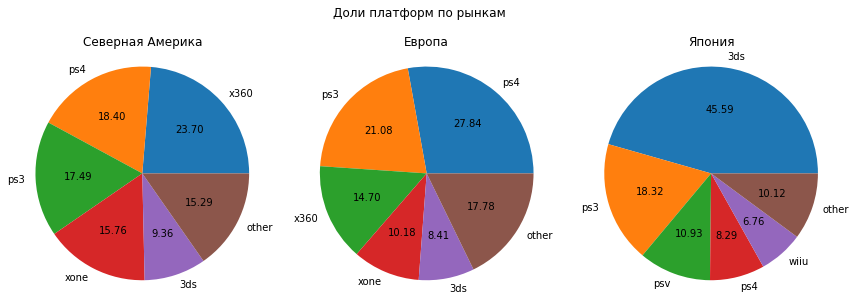

In [40]:
regional_top(data_filtered, 'platform')

Наблюдаем следующее:

- В Америке первенство по продажам игр за последние 5 лет удерживает Xbox 360, это домашний рынок для Microsoft. Однако на втором месте оказалась актуальная PS4, тогда как ее прямой конкурент Xbox One - лишь на четвертом.
- В Европе премущество на стороне Sony, причем PS4 заняла первое место. Xbox One по продажам игр вновь уступает своему предшественнику.
- Япония выделяется тем, что все 5 платформ с наибольшими продажами - это консоли японских производителей, три Sony и две Nintendo. Примечательно доминирование на рынке консоли handheld-формата - Nintendo 3DS, при этом в топ-5 также вошла PS Vita. Также это единственный рынок, где PS4 уступила по продажам игр PS3. Также низкая доля катгории other указывает на то, что консоли Microsoft, которые в нее попали, в Японии пользуются небольшой популярностью.

### Доли жанров на разных рынках

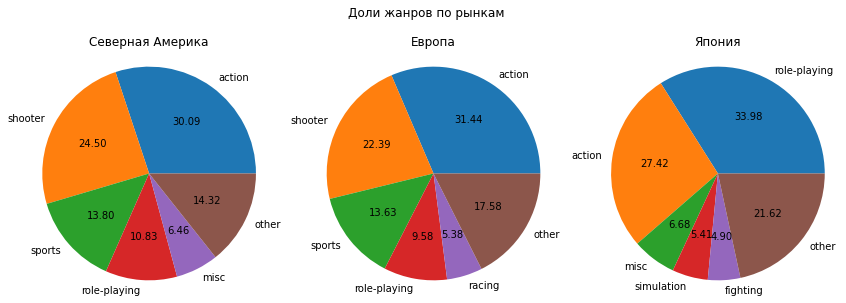

In [41]:
regional_top(data_filtered, 'genre')

Наблюдаем следующее:

- В Америке топ-5 жанров соответствуют мировым, но Sports опередила Role-Playing.
- В Европе топ-5 по жанрам отличается пятой позицией - там оказались гоночные игры.
- Япония вновь весьма самобытна - среди жанров первое место занял Role-Playing, тогда как Shooter, занимающий второе место в мире с лучшими медианными и квартильными значениями, вовсе не попал в топ-5. Также достаточно высока доля категории other, что говорит о том, что на этом рынке жанры вне топ-5 также имеют ощутимые продажи.

### Доли рейтингов ESRB на разных рынках

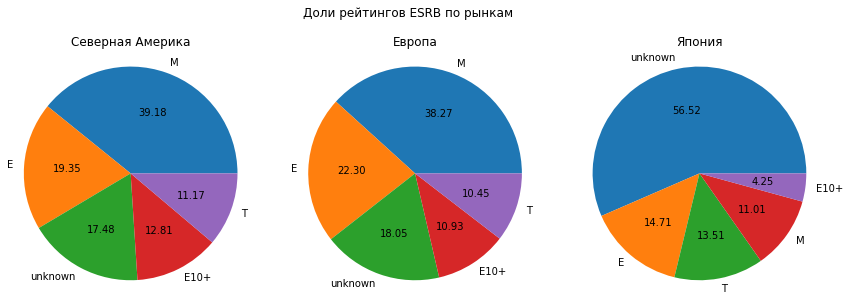

In [42]:
regional_top(data_filtered, 'rating')

Наблюдаем следующее:

- В Северной Америке наиболее широко представлен рейтинг M, следом идет E. Продажи игр без рейтинга (или с неизвестным рейтингом) оказались на третьем месте.
- В Европе картина полностью повторяется, не считая небольших отклонений в долях.
- Япония и тут стоит особняком - более 56% проданных игр относятся к категории unknown. Это можно объяснить тем, что в Японии существует собственное рейтинговое агенство CERO, а также тем, что много игр выходят только для японского рынка и не продаются за его пределами, соответственно, не получали рейтинг ESRB. Среди игр с известным рейтингом лидирующая в Америке и Европе категория M оказалась предпоследней.

## Проверка гипотез


In [43]:
# Зададим уровень статистической значимости
alpha = 0.05

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем нулевую и альтернативную гипотезу.

H<sub>0</sub>: Средний пользовательский рейтинг игр на платформе Xbox One *равен* среднему пользовательскому рейтингу на платформе PC. \
H<sub>1</sub>: Средний пользовательский рейтинг игр на платформе Xbox One *не равен* среднему пользовательскому рейтингу на платформе PC.

При проверке гипотезы избавимся от пустых значений в столбце `user_score`, и для платформы PC возьмем период, совпадающий с выходом на рынок Xbox One.

In [44]:
# Воспользуемся методом ttest_ind для t-теста двух независимых выборок.
# Поскольку размеры выборок могут отличаться, передадим параметру equal_var значение False.
# Поскольку гипотеза двусторонняя, параметр alternative указывать не нужно
results = st.ttest_ind(data_filtered.query('platform == "xone"')['user_score'].dropna(), 
                       data_filtered.query('(platform == "pc") and (year_of_release > 2012)')['user_score'].dropna(), 
                       equal_var=False)

print('p-value равно:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value равно: 0.14759594013430463
Не отвергаем нулевую гипотезу


Значение p-value говорит нам, что в гипотетической ситуации, когда нулевая гипотеза верна, результат, где средние рейтинги на платформах не равны, с вероятностью 14.76% является случайным.

Нулевую гипотезу отвергнуть не получилось, утверждать, что средние рейтинги игр на платформах не равны, мы не можем.

### Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем нулевую и альтернативную гипотезу. \
Для этого "развернем" заданный вопрос в обратную сторону, и будем исходить из равенства средних значений.

H<sub>0</sub>: Средний пользовательский рейтинг игр жанра Action *равен* среднему пользовательскому рейтингу жанра Sports. \
H<sub>1</sub>: Средний пользовательский рейтинг игр жанра Action *не равен* среднему пользовательскому рейтингу жанра Sports.

При проверке гипотезы избавимся от пустых значений в столбце `user_score`.

In [45]:
# Воспользуемся методом ttest_ind для t-теста двух независимых выборок.
# Поскольку размеры выборок могут отличаться, передадим параметру equal_var значение False.
# Поскольку гипотеза двусторонняя, параметр alternative указывать не нужно
results = st.ttest_ind(data_filtered.query('genre == "action"')['user_score'].dropna(), 
                       data_filtered.query('genre == "sports"')['user_score'].dropna(), 
                       equal_var=False)

print('p-value равно:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value равно: 5.989458066467418e-20
Отвергаем нулевую гипотезу


Таким образом, в гипотетической ситуации, когда нулевая гипотеза верна, вероятность того, что результат, где средние пользовательские рейтинги игр жанров Action и Sports не равны, случаен, ничтожно мала.

На заданный вопрос можно ответить, что средние рейтинги этих жанров действительно отличаются.

## Общий вывод

По итогам проведенного исследования было выявлено следущее:

1. В целом количество выпускаемых игр в последние годы сократилось после пика конца 2000-х - начала 2010-х.
2. Средний жизненный цикл платформ, на которых выходят игры, составляет 10 лет. 
 - На основе этого PS4 и Xbox One, вышедшие в 2013 году, на данный момент являются *наиболее актуальными*.
 - Также по прежнему пользуется популярностью 3DS, вышедшая в 2011 году.
 - Прошлое поколение консолей, таких, как Xbox 360, PS3 и Wii, *не перспективны* и в ближайшие годы уйдут с рынка.
3. Наиболее популярные игры за последние годы выходили на PS4 и 3DS (до 14 млн. проданных копий), на Xbox One и PC пиковые значения продаж ниже (около 8 млн.). Однако *медианное значение* продаж для всех платформ не превышает 400 тысяч.
4. При прогнозировании продаж можно частично опираться на оценки критиков, между этим показателями существует *умеренная* корреляция. С оценками пользователей такой корреляции нет.
5. Общемировое распределение продаж по жанрам за последние 5 лет:
 - Наиболее популярные жанры: Action, Shooter и Role-Playing.
 - Продажи в жанре Action в последние годы существенно *сократились*. Наиболее перспективным является жанр Shooter, с высокими значениями медианы и третьего квартиля.
 - Наименее популярные жанры: Puzzle, Strategy и Adventure.
 - Продажи в этих жанрах в последние годы были стабильно *невысокими*.

Также были составлены портреты пользователей по регионам:

1. Северная Америка:
 - Наиболее популярен Xbox 360, но его продажи стремительно сокращаются. Из актуальных консолей лидирует PS4.
 - Самые популярные жанры совпадают с общемировыми: Action, Shooter, Sports и Role-Playing.
 - Наиболее популярны игры с рейтингами M и E.
2. Европа:
 - Лидируют консоли Sony, PS4 на первом месте.
 - Самые популярные жанры также совпадают с общемировыми, также в топ-5 вошла категория Racing.
 - Как и в Америке, наиболее популярны игры с рейтингами M и E.
3. Япония:
 - Наиболее популярна 3DS, преобладают консоли handheld-формата, весь топ-5 заняли консоли японских производителей. Доля Microsoft крайне мала.
 - Самые популярные жанры - Role-Playing и Action. Популярный во всем остальном мире жанр Shooter в топ-5 не вошел. Доля жанров вне топ-5 достаточно высока.
 - Большая часть проданных игр не имеет рейтинга ESRB (или же он нам неизвестен). Лидирующая в Америке и Европе категория M оказалась предпоследней.


Также были проверены две гипотезы:
- О равенстве средних пользовательских рейтингов на платформах Xbox One и PC - гипотеза **не отвергнута**.
- О равенстве средних пользовательских рейтингов жанров Action и Sports - гипотеза **отвергнута**.